In this notebook we construct a function to simulate images of lenses with convergence maps taken from Illustris and images from the PROBES dataset as sources. It's *nearly* as simple as possible: the one complexity is that the image is first simulated on a fine grid and then downsampled to the target one.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

from astropy.visualization import make_lupton_rgb
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from caustic.constants import rad_to_arcsec
from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.data import PROBESDataset, IllustrisKappaDataset
from caustic.lenses import KappaGrid
from caustic.parametrized import Parametrized
from caustic.sources import ImageSource
from caustic.utils import get_meshgrid


device = "cpu"
kappa_path = "../../data/hkappa356hst_TNG100_rau_spl_trainset_0.5kpc_z0/data_1.h5"
probes_path = "../../data/probes.h5"

Create simulator. This indexes into the lens and source datasets, performs the ray-tracing and source interpolation, and downsamples.

In [4]:
ds_probes = PROBESDataset(probes_path)
ds_illustris = IllustrisKappaDataset(kappa_path)
cosmology = FlatLambdaCDMCosmology("cosmo")

z_s = torch.tensor(2.3, device=device)
z_l = torch.tensor(1.5, device=device)
pix_Mpc = 0.5 * 1e-3
n_pix = ds_illustris.n_pix
fov_Mpc = pix_Mpc * n_pix
fov = fov_Mpc / cosmology.angular_diameter_dist(z_l) * rad_to_arcsec
res = fov / n_pix

In [5]:
class Simulator(Parametrized):
    def __init__(
        self,
        name,
        cosmology,
        res,
        n_pix,
        z_l,
        z_s,
        upsample_factor=4,
        device=torch.device("cpu"),
    ):
        super().__init__(name)
        self.upsample_factor = upsample_factor
        self.add_param("z_s", torch.as_tensor(z_s, device=device))

        self._thx_fine, self._thy_fine = get_meshgrid(
            res / upsample_factor,
            upsample_factor * n_pix,
            upsample_factor * n_pix,
            device,
        )

        self.lens = KappaGrid(
            "kg",
            fov,
            n_pix,
            cosmology,
            z_l=z_l,
            kappa_map_shape=(n_pix, n_pix),
        )
        self.src = ImageSource(
            "img-src",
            thx0=torch.tensor(0.0, device=device),
            thy0=torch.tensor(0.0, device=device),
            scale=torch.tensor(1.0, device=device),
        )

    def __call__(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)

        bx, by = self.lens.raytrace(self._thx_fine, self._thy_fine, z_s, x)
        mu_fine = self.src.brightness(bx, by, x)
        return F.avg_pool2d(mu_fine, self.upsample_factor)[0]

In [6]:
sim = Simulator("sim", cosmology, res, n_pix, z_l, z_s)

# For plotting
extent = (-fov / 2, fov / 2, -fov / 2, fov / 2)

In [7]:
print(sim)

Simulator(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('kg': ['kappa_map']), ('img-src': ['image'])]
)


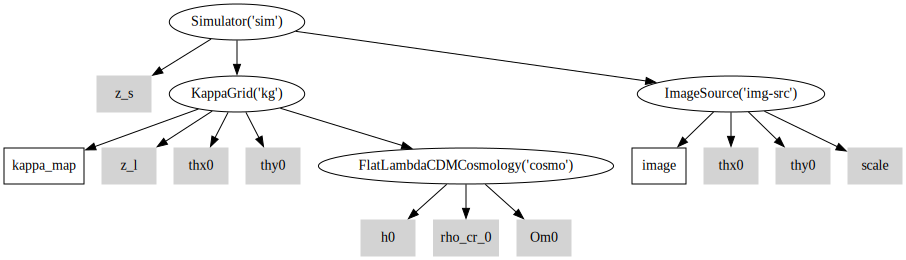

In [11]:
sim.get_graph(True, True)

Select random indices

In [9]:
idx_lens = torch.randint(len(ds_illustris), size=())
idx_src = torch.randint(len(ds_probes), size=())

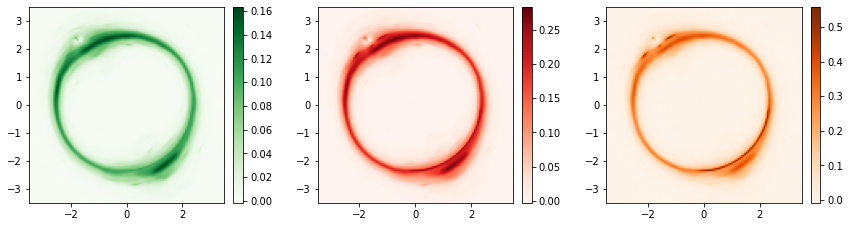

In [10]:
x = [ds_illustris[idx_lens][None, None], ds_probes[idx_src][None]]
image = sim(x)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.25))
for ax, channel, cmap in zip(axs, image, ["Greens", "Reds", "Oranges"]):
    im = ax.imshow(channel, extent=extent, origin="lower", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)

fig.tight_layout()